
# <center>Estudio imagenes numeros MNIST</center>
# <center>con distintos algoritmos de clasificacion</center>

**Índice**   
1. [KNN](#id1)
2. [Arbol de decisión](#id2)
3. [SVM](#id3)
4. [Regresión Logística](#id4)
5. [Random Forest](#id5)
6. [XGBoost](#id6)

Carguemos las librerías necesarias

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


### Acerca del set de datos

MNIST dataset is derived from the NIST dataset. It contains 60000 training and 10000 testing images of size 28x28 in grayscale. Digits have been recentered on the raster using the center of mass.

### Cargar Datos a partir de un archivo gz descomprimido en la misma carpeta

In [2]:
import idx2numpy

# Ojo no reconoce el caracter ~y he tenido que dejar los ficheros en la misma carpeta que el ipynb
file = "train-images-idx3-ubyte"
xTrain = idx2numpy.convert_from_file(file)
file = "t10k-images-idx3-ubyte"
xTest = idx2numpy.convert_from_file(file)
file = "train-labels-idx1-ubyte"
yTrain = idx2numpy.convert_from_file(file)
file = "t10k-labels-idx1-ubyte"
yTest = idx2numpy.convert_from_file(file)


In [3]:
xTrain = xTrain / 255.
xTest  = xTest  / 255.

digitClasses = np.array([str(d) for d in range(10)])

xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [4]:
#el array 2D lo paso a vector 1d como entrada al algoritmo
xTrain_flat = np.reshape(xTrain, (60000,784))
xTest_flat = np.reshape(xTest, (10000,784))

# Visualización de Datos y Análisis 



Puedes explorar fácilmente tus datos utilizando técnicas de visualización:

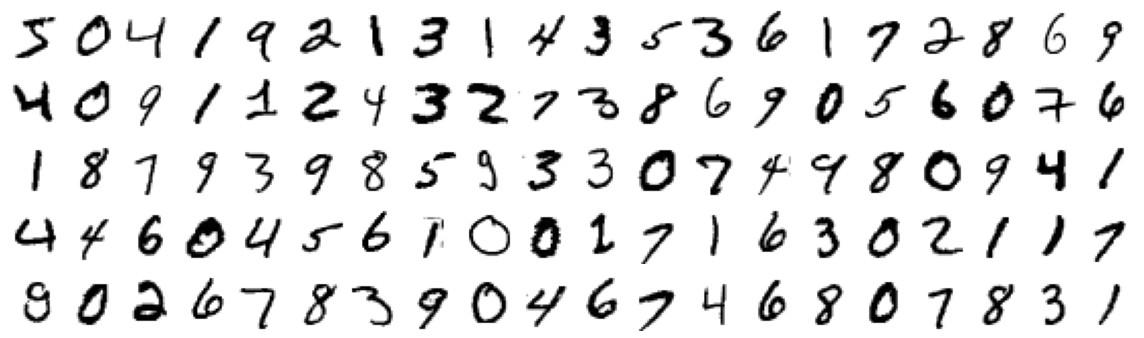

In [5]:
fig, axes = plt.subplots(5, 20, figsize=(16, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(xTrain[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

## Normalizacion y Train Test Split  
Ya está hecho arriba

# Clasificación 

<a name="id1"></a>
## K-vecinos más cercano (K-NN)

### Entrenamiento

Iteramos con el algoritmo para diferentes K:

In [37]:
Ks = 6
mean_acc = np.zeros((Ks-3))
std_acc = np.zeros((Ks-3))

for n in range(3,Ks):
    #Entrenar el Modelo y Predecir  
    neigh = KNeighborsClassifier(n_neighbors = n)
    neigh.fit(xTrain_flat, yTrain)
    yhat = neigh.predict(xTest_flat)
    # Guardo la precisión
    mean_acc[n-3] = accuracy_score(yTest, yhat) 
    std_acc[n-3]=np.std(yhat==yTest)/np.sqrt(yhat.shape[0])


#### Dibujo de la certeza del modelo para diferentes números de vecinos

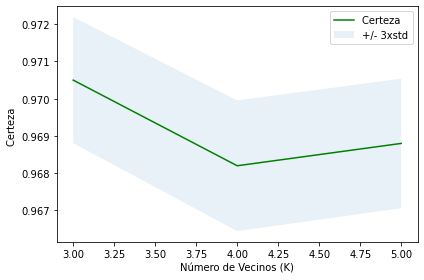

In [38]:
plt.plot(range(3,Ks),mean_acc,'g')
plt.fill_between(range(3,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vecinos (K)')
plt.tight_layout()
plt.show()

In [39]:
print( "La mejor aproximación de certeza fue con ", mean_acc.max(), "con k=", mean_acc.argmax()+3)

La mejor aproximación de certeza fue con  0.9705 con k= 3


In [40]:
#Me quedo con el modelo mejor y lo entreno con Xtrain e Ytrain
knn_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+3)
knn_model.fit(xTrain_flat, yTrain)

#Hago predicción con X test y lo comparo con y test
ypred = knn_model.predict(xTrain_flat)
yhat = knn_model.predict(xTest_flat)
  
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
knn_acc_train = accuracy_score(yTrain, ypred)
knn_acc_test = accuracy_score(yTest, yhat)

print("Precisión de entrenamiento: ", knn_acc_train)
print("Precisión de test: ", knn_acc_test)
knn_model


Precisión de entrenamiento:  0.9867166666666667
Precisión de test:  0.9705


KNeighborsClassifier(n_neighbors=3)

In [41]:
print(confusion_matrix(yTest, yhat, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat))

[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  10    9  996    2    0    0    0   13    2    0]
 [   0    2    4  976    1   13    1    7    3    3]
 [   1    6    0    0  950    0    4    2    0   19]
 [   6    1    0   11    2  859    5    1    3    4]
 [   5    3    0    0    3    3  944    0    0    0]
 [   0   21    5    0    1    0    0  991    0   10]
 [   8    2    4   16    8   11    3    4  914    4]
 [   4    5    2    8    9    2    1    8    2  968]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96   

<a name="id2"></a>
## Arbol de decisión

### Modelado y entrenamiento

In [42]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [10, 50, 100],
                 'max_depth'   : [10, 50, 100],
                 'criterion'   : [ 'entropy','gini']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    modelo = DecisionTreeClassifier(        
                random_state = 123,
                ** params
             )
    
    modelo.fit(xTrain_flat, yTrain)
    yhat= modelo.predict(xTest_flat)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(yTest,yhat))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(7)

Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 50} ✓


,accuracy,criterion,max_depth,max_features
5,0.8729,entropy,50,100
8,0.8729,entropy,100,100
17,0.8680,gini,100,100
14,0.8680,gini,50,100
4,0.8630,entropy,50,50
7,0.8630,entropy,100,50
16,0.8602,gini,100,50


In [43]:
#Creo el modelo y lo entreno con X e Y train
resultados = resultados.reset_index(drop=True)
dt_model = DecisionTreeClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
dt_model.fit(xTrain_flat,yTrain)

#Hago predicción con X test y lo comparo con y test
ypred = dt_model.predict(xTrain_flat)
yhat2 = dt_model.predict(xTest_flat)
 
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
dt_acc_train = accuracy_score(yTrain, ypred)
dt_acc_test = accuracy_score(yTest, yhat2)

print("Precisión de entrenamiento: ", dt_acc_train)
print("Precisión de test: ", dt_acc_test)
dt_model


Precisión de entrenamiento:  1.0
Precisión de test:  0.8719


DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features=100)

In [44]:
print(confusion_matrix(yTest, yhat2, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat2))

[[ 920    1    9    1    4   19   14    3    7    2]
 [   0 1098    8    3    0    5    5    3    9    4]
 [  12   15  874   22   17   13   10   28   35    6]
 [   8    9   23  850    8   51    1   15   25   20]
 [   3    2   15    7  839   12   17    7   27   53]
 [  12    6   10   62   12  723   16   10   24   17]
 [  18    4   15    6   19   14  860    3   16    3]
 [   2   11   25   13    7    6    7  918    6   33]
 [   6    3   33   26   28   35   15   15  789   24]
 [   3    3    9   11   55   19   12   24   25  848]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.86      0.85      0.85      1032
           3       0.85      0.84      0.85      1010
           4       0.85      0.85      0.85       982
           5       0.81      0.81      0.81       892
           6       0.90      0.90      0.90       958
           7       0.89      0.89   

In [45]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
462,462,0.087372
318,318,0.066199
378,378,0.055672
541,541,0.042528
377,377,0.034545
...,...,...
255,255,0.000000
254,254,0.000000
253,253,0.000000
252,252,0.000000


In [46]:
# #Preparo las etiquetas del arbol
# a = np.asarray(range(784))
# featureNames = a.astype('str')
# targetNames = sorted(np.unique(yTrain).astype('str'))

# #Esto Genera bien el fichero .dot
# # arbol_dot = tree.export_graphviz(drugTree, out_file='drugtree.dot',
# #                                  feature_names=featureNames, class_names=targetNames ,
# #                                  filled=True, special_characters=True)  

# #Esto pinta bien el arbol, hay que poner antes el tamaño de la figura, sino lo hace muy pequeño
# plt.figure(figsize=(10, 10))
# plot_tree(dt_model, feature_names=featureNames, class_names=targetNames, filled=True, rounded=True,)
# plt.show()

<a name="id3"></a>
## SVM Support Vector Machines 

In [47]:
# Itero con los 4 posibles kernel de SVM para ver cual es el mejor
kernel_params=['linear','poly','rbf']  #,'sigmoid'] da un 77.6%
acc_svm = pd.DataFrame(index=kernel_params)

for i in kernel_params:
    svm_model = svm.SVC(kernel=i)
    svm_model.fit(xTrain_flat, yTrain)
    yhat3 = svm_model.predict(xTest_flat)
    acc_svm.at[i,'accuracy'] = accuracy_score(yTest, yhat3)

# Extraigo el mejor
mejor_kernel = acc_svm[acc_svm['accuracy']==acc_svm['accuracy'].max()].index
mejor_kernel = np.array(mejor_kernel).astype('str')
print('El mejor kernel es ', mejor_kernel[0],'con una precisión de: ',acc_svm['accuracy'].max())
acc_svm  

El mejor kernel es  rbf con una precisión de:  0.9792


,accuracy
linear,0.9404
poly,0.9771
rbf,0.9792


In [48]:
# Construyo el modelo final con ese Kernel
svm_model = svm.SVC(kernel=mejor_kernel[0])
svm_model.fit(xTrain_flat,yTrain)


#Hago predicción con X train y test
ypred = svm_model.predict(xTrain_flat)
yhat3 = svm_model.predict(xTest_flat)

svm_acc_train = accuracy_score(yTrain, ypred)
svm_acc_test = accuracy_score(yTest, yhat3)

print("Precisión de entrenamiento: ", svm_acc_train)
print("Precisión de test: ", svm_acc_test)

svm_model

Precisión de entrenamiento:  0.9899166666666667
Precisión de test:  0.9792


SVC()

In [49]:
print(confusion_matrix(yTest, yhat3, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat3))

[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1126    3    1    0    1    1    1    2    0]
 [   6    1 1006    2    1    0    2    7    6    1]
 [   0    0    2  995    0    2    0    5    5    1]
 [   0    0    5    0  961    0    3    0    2   11]
 [   2    0    0    9    0  871    4    1    4    1]
 [   6    2    0    0    2    3  944    0    1    0]
 [   0    6   11    1    1    0    0  996    2   11]
 [   3    0    2    6    3    2    2    3  950    3]
 [   3    4    1    7   10    2    1    7    4  970]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97   

<a name="id4"></a>
## Regresion Logística

In [50]:
# Itero con los 5 posibles Solver de Reg Logística para ver cual es el mejor
solver_params=['lbfgs','liblinear','newton-cg']  #,'sag','saga'] dan lo mismo que newton
acc_lr = pd.DataFrame(index=solver_params)

for i in solver_params:
    lr_model = LogisticRegression(C=0.01, solver=i)
    lr_model.fit(xTrain_flat, yTrain)
    y_hat7 = lr_model.predict(xTest_flat)
    acc_lr.at[i,'accuracy'] = accuracy_score(yTest, y_hat7)

# Extraigo el mejor
mejor_solver = acc_lr[acc_lr['accuracy']==acc_lr['accuracy'].max()].index
mejor_solver = np.array(mejor_solver).astype('str')
print('El mejor kernel es ', mejor_solver[0],'con una precisión de: ',acc_lr['accuracy'].max())
acc_lr  


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El mejor kernel es  lbfgs con una precisión de:  0.9189


,accuracy
lbfgs,0.9189
liblinear,0.9123
newton-cg,0.9187


In [51]:
# Construyo el modelo final con ese Solver
lr_model = LogisticRegression(C=0.01,solver=mejor_solver[0])
lr_model.fit(xTrain_flat, yTrain)

#Hago predicción con X train y test
ypred = lr_model.predict(xTrain_flat)
yhat4 = lr_model.predict(xTest_flat)

lr_acc_train = accuracy_score(yTrain, ypred)
lr_acc_test = accuracy_score(yTest, yhat4)

print("Precisión de entrenamiento: ", lr_acc_train)
print("Precisión de test: ", lr_acc_test)

lr_model

Precisión de entrenamiento:  0.9185333333333333
Precisión de test:  0.9189


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01)

In [52]:
print(confusion_matrix(yTest, yhat4, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat4))

[[ 960    0    2    1    0    5    9    1    2    0]
 [   0 1109    2    2    0    2    4    2   14    0]
 [   9    9  911   16   13    2   15   13   36    8]
 [   3    1   22  915    0   25    2   14   16   12]
 [   1    4    2    1  917    1   11    2    9   34]
 [  10    3    2   36    8  778   16    6   27    6]
 [  12    3    4    1   10   14  908    3    3    0]
 [   2   12   22    9    6    0    0  940    2   35]
 [   7   10    7   23    9   32   11   11  853   11]
 [  11    8    2   11   36    8    0   27    8  898]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.93      0.95      0.94       958
           7       0.92      0.91   

<a name="id5"></a>
## Random Forest

In [53]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [10, 50, 100],
                 'max_depth'   : [10, 50],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                n_estimators= 100,        
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(xTrain_flat, yTrain)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 50, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 10} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100} ✓


,oob_accuracy,criterion,max_depth,max_features
0,0.967033,entropy,50,100
1,0.966567,gini,50,100
2,0.965933,entropy,50,50
3,0.965733,gini,50,50


In [54]:
#Creo el modelo y lo entreno con X e Y train
rf_model = RandomForestClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
rf_model.fit(xTrain_flat, yTrain)

#Hago predicción con Xtrain y Xtest
ypred = rf_model.predict(xTrain_flat)
yhat5 = rf_model.predict(xTest_flat)

# Saco la precisión del modelo con set de entrenamiento y con conjunto de test
rf_acc_train = accuracy_score(yTrain, ypred)
rf_acc_test = accuracy_score(yTest, yhat5)

print("Precisión de entrenamiento: ", rf_acc_train)
print("Precisión de test: ", rf_acc_test)

rf_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.9703


RandomForestClassifier(criterion='entropy', max_depth=50, max_features=100)

In [55]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': rf_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
568,568,0.020097
350,350,0.018937
378,378,0.015828
155,155,0.014371
461,461,0.014086
...,...,...
336,336,0.000000
337,337,0.000000
364,364,0.000000
365,365,0.000000


In [56]:
print(confusion_matrix(yTest, yhat5, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat5))

[[ 971    1    0    0    0    2    2    1    2    1]
 [   0 1122    1    6    0    2    2    1    1    0]
 [   6    0 1001    4    2    0    5    9    5    0]
 [   1    0   11  972    0    7    0   10    6    3]
 [   1    0    0    0  954    0    5    0    5   17]
 [   4    0    0   12    2  857    7    3    5    2]
 [   6    3    0    0    4    4  937    0    4    0]
 [   1    2   20    2    1    0    0  994    4    4]
 [   3    0    5    4    6    3    7    3  933   10]
 [   6    6    2    6   12    3    1    5    6  962]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.97   

<a name="id6"></a>
## XGBoost

[0]	validation_0-merror:0.17212	validation_0-mlogloss:2.27024	validation_1-merror:0.17410	validation_1-mlogloss:2.27033
[1]	validation_0-merror:0.16757	validation_0-mlogloss:2.23917	validation_1-merror:0.17230	validation_1-mlogloss:2.23949
[2]	validation_0-merror:0.16067	validation_0-mlogloss:2.20886	validation_1-merror:0.16630	validation_1-mlogloss:2.20932
[3]	validation_0-merror:0.15825	validation_0-mlogloss:2.17957	validation_1-merror:0.16360	validation_1-mlogloss:2.18024
[4]	validation_0-merror:0.15477	validation_0-mlogloss:2.15132	validation_1-merror:0.15850	validation_1-mlogloss:2.15212
[5]	validation_0-merror:0.15055	validation_0-mlogloss:2.12411	validation_1-merror:0.15590	validation_1-mlogloss:2.12504
[6]	validation_0-merror:0.14830	validation_0-mlogloss:2.09774	validation_1-merror:0.15250	validation_1-mlogloss:2.09883
[7]	validation_0-merror:0.14657	validation_0-mlogloss:2.07225	validation_1-merror:0.15140	validation_1-mlogloss:2.07341
[8]	validation_0-merror:0.14310	validati

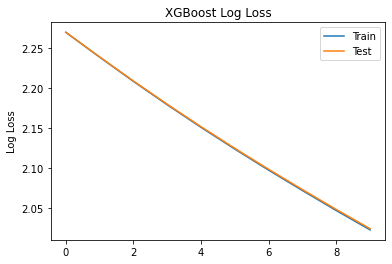

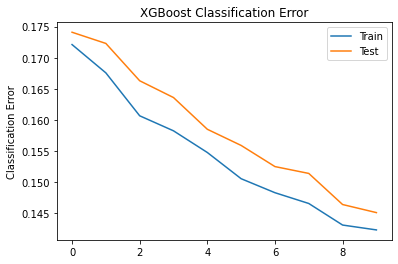

Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.05795	validation_0-mlogloss:2.26058	validation_1-merror:0.10350	validation_1-mlogloss:2.26245
[1]	validation_0-merror:0.05460	validation_0-mlogloss:2.22039	validation_1-merror:0.09730	validation_1-mlogloss:2.22410
[2]	validation_0-merror:0.05287	validation_0-mlogloss:2.18194	validation_1-merror:0.09430	validation_1-mlogloss:2.18731
[3]	validation_0-merror:0.05182	validation_0-mlogloss:2.14500	validation_1-merror:0.09390	validation_1-mlogloss:2.15209
[4]	validation_0-merror:0.05078	validation_0-mlogloss:2.10941	validation_1-merror:0.09320	validation_1-mlogloss:2.11823
[5]	validation_0-merror:0.05047	validation_0-mlogloss:2.07518	validation_1-merror:0.09400	validation_1-mlogloss:2.08562
[6]	validation_0-merror:0.04965	validation_0-mlogloss:2.04218	validation_1-merror:0.09250	validation_1-mlogloss:2.05425
[7]	validation_0-merror:0.04923	validation_0-mlogloss:2.01032	validation_1-merror:0.09190	validation_1-mlogloss:2.02392
[8]	validation_0-merror:0.04830	validati

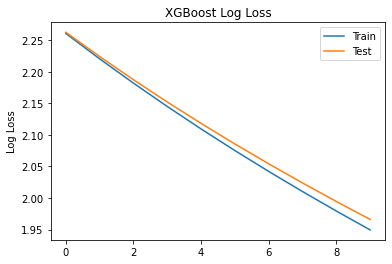

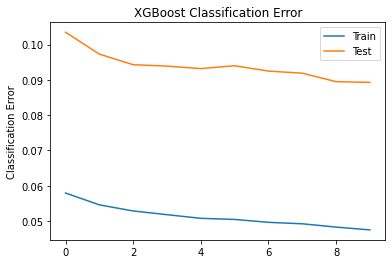

Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.17212	validation_0-mlogloss:2.14261	validation_1-merror:0.17410	validation_1-mlogloss:2.14317
[1]	validation_0-merror:0.15130	validation_0-mlogloss:2.00876	validation_1-merror:0.15470	validation_1-mlogloss:2.00994
[2]	validation_0-merror:0.14027	validation_0-mlogloss:1.89380	validation_1-merror:0.14300	validation_1-mlogloss:1.89598
[3]	validation_0-merror:0.12462	validation_0-mlogloss:1.79195	validation_1-merror:0.12960	validation_1-mlogloss:1.79506
[4]	validation_0-merror:0.12013	validation_0-mlogloss:1.70249	validation_1-merror:0.12940	validation_1-mlogloss:1.70643
[5]	validation_0-merror:0.11308	validation_0-mlogloss:1.62116	validation_1-merror:0.12080	validation_1-mlogloss:1.62574
[6]	validation_0-merror:0.11010	validation_0-mlogloss:1.54833	validation_1-merror:0.11830	validation_1-mlogloss:1.55323
[7]	validation_0-merror:0.10748	validation_0-mlogloss:1.48074	validation_1-merror:0.11400	validation_1-mlogloss:1.48631
[8]	validation_0-merror:0.10542	validati

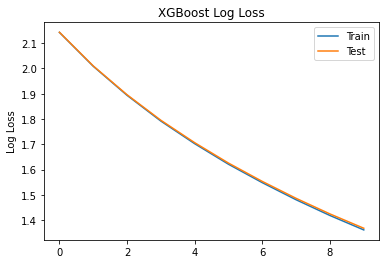

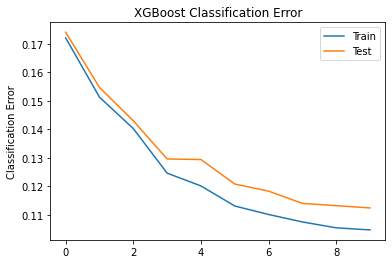

Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.05795	validation_0-mlogloss:2.09500	validation_1-merror:0.10350	validation_1-mlogloss:2.10434
[1]	validation_0-merror:0.05077	validation_0-mlogloss:1.92816	validation_1-merror:0.09330	validation_1-mlogloss:1.94560
[2]	validation_0-merror:0.04642	validation_0-mlogloss:1.78839	validation_1-merror:0.08720	validation_1-mlogloss:1.81265
[3]	validation_0-merror:0.03833	validation_0-mlogloss:1.66689	validation_1-merror:0.07770	validation_1-mlogloss:1.69692
[4]	validation_0-merror:0.03437	validation_0-mlogloss:1.56000	validation_1-merror:0.07250	validation_1-mlogloss:1.59605
[5]	validation_0-merror:0.03162	validation_0-mlogloss:1.46459	validation_1-merror:0.06870	validation_1-mlogloss:1.50597
[6]	validation_0-merror:0.02957	validation_0-mlogloss:1.37850	validation_1-merror:0.06690	validation_1-mlogloss:1.42490
[7]	validation_0-merror:0.02857	validation_0-mlogloss:1.30028	validation_1-merror:0.06480	validation_1-mlogloss:1.35130
[8]	validation_0-merror:0.02680	validati

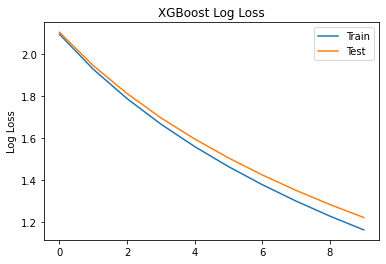

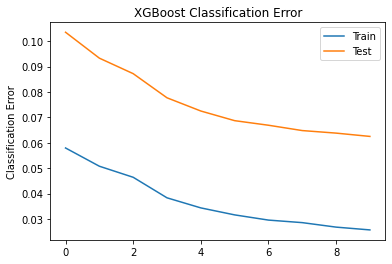

Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.17212	validation_0-mlogloss:1.98783	validation_1-merror:0.17410	validation_1-mlogloss:1.98893
[1]	validation_0-merror:0.13867	validation_0-mlogloss:1.76554	validation_1-merror:0.14660	validation_1-mlogloss:1.76837
[2]	validation_0-merror:0.12173	validation_0-mlogloss:1.59419	validation_1-merror:0.12890	validation_1-mlogloss:1.59873
[3]	validation_0-merror:0.11053	validation_0-mlogloss:1.45319	validation_1-merror:0.11850	validation_1-mlogloss:1.45895
[4]	validation_0-merror:0.10535	validation_0-mlogloss:1.33260	validation_1-merror:0.11330	validation_1-mlogloss:1.33942
[5]	validation_0-merror:0.10197	validation_0-mlogloss:1.23125	validation_1-merror:0.10960	validation_1-mlogloss:1.23888
[6]	validation_0-merror:0.09747	validation_0-mlogloss:1.14162	validation_1-merror:0.10450	validation_1-mlogloss:1.14993
[7]	validation_0-merror:0.09452	validation_0-mlogloss:1.06146	validation_1-merror:0.10040	validation_1-mlogloss:1.07090
[8]	validation_0-merror:0.09125	validati

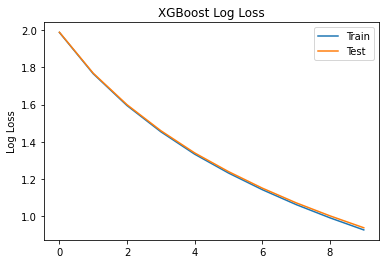

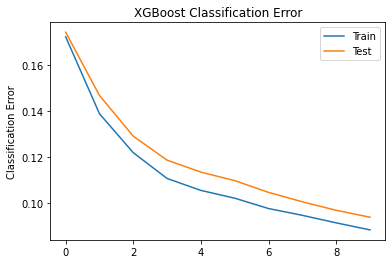

Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.05795	validation_0-mlogloss:1.89430	validation_1-merror:0.10350	validation_1-mlogloss:1.91292
[1]	validation_0-merror:0.04268	validation_0-mlogloss:1.62804	validation_1-merror:0.08550	validation_1-mlogloss:1.65958
[2]	validation_0-merror:0.03473	validation_0-mlogloss:1.42631	validation_1-merror:0.07240	validation_1-mlogloss:1.46835
[3]	validation_0-merror:0.03043	validation_0-mlogloss:1.26398	validation_1-merror:0.06770	validation_1-mlogloss:1.31518
[4]	validation_0-merror:0.02735	validation_0-mlogloss:1.12923	validation_1-merror:0.06380	validation_1-mlogloss:1.18863
[5]	validation_0-merror:0.02508	validation_0-mlogloss:1.01472	validation_1-merror:0.06080	validation_1-mlogloss:1.08190
[6]	validation_0-merror:0.02318	validation_0-mlogloss:0.91600	validation_1-merror:0.06000	validation_1-mlogloss:0.98949
[7]	validation_0-merror:0.02220	validation_0-mlogloss:0.83032	validation_1-merror:0.05730	validation_1-mlogloss:0.90853
[8]	validation_0-merror:0.02067	validati

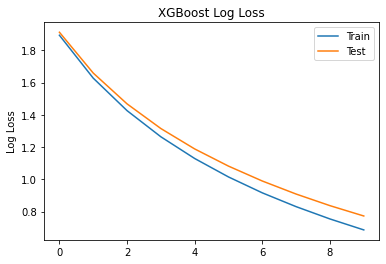

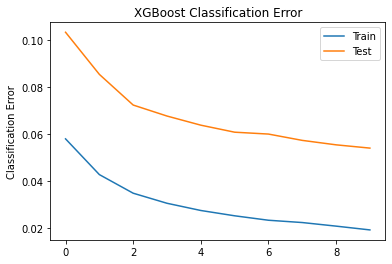

Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 10} ✓


,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.9460,0.1,0.10,10.0,10.0
1,0.9375,0.1,0.05,10.0,10.0
2,0.9107,0.1,0.01,10.0,10.0
3,0.9063,0.1,0.10,5.0,10.0
4,0.8876,0.1,0.05,5.0,10.0
5,0.8549,0.1,0.01,5.0,10.0


In [31]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [10],
                 'learning_rate': [0.1, 0.5, 1],
                 'max_depth'   : [3, 5],
                 'gamma' : [0.1]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    xgb_model = XGBClassifier(
                ** params
             )

    eval_set = eval_set = [(xTrain_flat, yTrain), (xTest_flat, yTest)]
    xgb_model.fit(xTrain_flat, yTrain, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
    
    # retrieve performance metrics
    results = xgb_model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

    yhat6= xgb_model.predict(xTest_flat)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(yTest,yhat6))
    print(f"Modelo: {params} \u2713")

    
    
# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(7)

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.30690	validation_0-mlogloss:1.38380	validation_1-merror:0.30300	validation_1-mlogloss:1.37625
[1]	validation_0-merror:0.22037	validation_0-mlogloss:1.06617	validation_1-merror:0.22100	validation_1-mlogloss:1.06139
[2]	validation_0-merror:0.18387	validation_0-mlogloss:0.87367	validation_1-merror:0.18400	validation_1-mlogloss:0.86782
[3]	validation_0-merror:0.16127	validation_0-mlogloss:0.74031	validation_1-merror:0.16220	validation_1-mlogloss:0.73640
[4]	validation_0-merror:0.14573	validation_0-mlogloss:0.64864	validation_1-merror:0.14580	validation_1-mlogloss:0.64487
[5]	validation_0-merror:0.13293	validation_0-mlogloss:0.57307	validation_1-merror:0.13550	validation_1-mlogloss:0.57268
[6]	validation_0-merror:0.12383	validation_0-mlogloss:0.51752	validation_1-merror:0.12540	validation_1-mlogloss:0.51966
[7]	validation_0-merror:0.11495	validation_0-mlogloss:0.46922	validation_1-merror:0.11720	validation_1-mlogloss:0.47214
[8]	validation_0-merror:0.10655	validati

[68]	validation_0-merror:0.01428	validation_0-mlogloss:0.06578	validation_1-merror:0.03720	validation_1-mlogloss:0.12082
[69]	validation_0-merror:0.01362	validation_0-mlogloss:0.06448	validation_1-merror:0.03680	validation_1-mlogloss:0.11983
[70]	validation_0-merror:0.01330	validation_0-mlogloss:0.06332	validation_1-merror:0.03660	validation_1-mlogloss:0.11911
[71]	validation_0-merror:0.01298	validation_0-mlogloss:0.06201	validation_1-merror:0.03640	validation_1-mlogloss:0.11849
[72]	validation_0-merror:0.01270	validation_0-mlogloss:0.06085	validation_1-merror:0.03600	validation_1-mlogloss:0.11763
[73]	validation_0-merror:0.01237	validation_0-mlogloss:0.05947	validation_1-merror:0.03590	validation_1-mlogloss:0.11629
[74]	validation_0-merror:0.01190	validation_0-mlogloss:0.05831	validation_1-merror:0.03590	validation_1-mlogloss:0.11594
[75]	validation_0-merror:0.01152	validation_0-mlogloss:0.05729	validation_1-merror:0.03560	validation_1-mlogloss:0.11549
[76]	validation_0-merror:0.01122

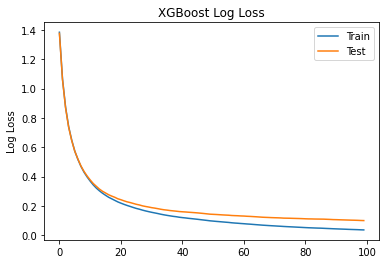

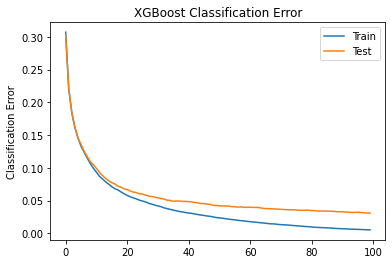

Precisión del Arbol de entrenamiento:  0.9948
Precisión del Arbol de test:  0.9691


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
#Creo el modelo con mejores parámetros y lo entreno con X e Y train
xgb_model = XGBClassifier(n_estimators = 100,
                          learning_rate = 0.5,
                          max_depth = 3,
                          gamma = 0.1)

xgb_model.fit(xTrain_flat, yTrain, 
              eval_metric=["merror", "mlogloss"], eval_set=eval_set, 
              early_stopping_rounds=5, verbose=True)

# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

ypred = xgb_model.predict(xTrain_flat)
yhat6 = xgb_model.predict(xTest_flat)

xgb_acc_train = accuracy_score(yTrain, ypred)
xgb_acc_test = accuracy_score(yTest, yhat6)

print("Precisión del Arbol de entrenamiento: ", xgb_acc_train)
print("Precisión del Arbol de test: ", xgb_acc_test)
xgb_model

In [67]:
importancia_predictores = pd.DataFrame(
                            {'predictor': range(784),
                             'importancia': xgb_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
67,67,0.064998
70,70,0.055118
220,220,0.045512
277,277,0.031514
101,101,0.028053
...,...,...
252,252,0.000000
251,251,0.000000
250,250,0.000000
227,227,0.000000


In [68]:
print(confusion_matrix(yTest, yhat6, labels=sorted(np.unique(yTrain))))
print (classification_report(yTest, yhat6))

[[ 968    0    0    0    0    4    3    1    4    0]
 [   0 1123    3    2    1    0    2    0    4    0]
 [   3    0  994    7    7    0    1    6   10    4]
 [   0    0    4  983    0    6    2    7    8    0]
 [   2    0    5    0  952    0    3    2    4   14]
 [   2    2    1   11    1  857    7    3    6    2]
 [   7    3    2    0    3    7  930    1    5    0]
 [   0    2   18    6    1    0    0  980    1   20]
 [   4    1    2    6    5    4    3    4  938    7]
 [   4    5    2    5   11    3    1    8    4  966]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.97      0.95   

In [70]:
Resultado_total = pd.DataFrame(
            {'Algoritmo':('KNN','Decision Tree','SVM','Logistic Regression','Random Forest','XGBoost'),
             'Precisión Test':(knn_acc_test, dt_acc_test, svm_acc_test, lr_acc_test, rf_acc_test, xgb_acc_test),             
            'Precisión Entrenam':(knn_acc_train, dt_acc_train, svm_acc_train, lr_acc_train, rf_acc_train, xgb_acc_train)
             })
Resultado_total.sort_values('Precisión Test', ascending=False)

,Algoritmo,Precisión Test,Precisión Entrenam
2,SVM,0.9792,0.989917
0,KNN,0.9705,0.986717
4,Random Forest,0.9703,1.000000
5,XGBoost,0.9691,0.994800
3,Logistic Regression,0.9189,0.918533
1,Decision Tree,0.8719,1.000000
